In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import tqdm as notebook_tqdm

torch.manual_seed(1)

We try to predict the quality of red wine, given 11 features.  
To do so, we contrast 3 different ML pipelines.
- Fitting a NN on the original features of the data.
- Using PCA to reduce the dimensionality of the feature space, then fitting a model on the principle components.
- First training an AE, then fit a model using on the latent space of the AE.

Before we do so, we first create a training, validation and test set and dataloader.

In [2]:
data = pd.read_csv("winequality-red.csv")
data = data.astype('float32')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


In [3]:
n = len(data)
train = int(n * 0.8)
val = int(n * 0.1)

#normalize, using only the stats of the training set, to avoid information about the 
#val and test sets to leak.
train_set = data[:train]
data = (data-train_set.mean())/train_set.std()

train_set = data[:train]
val_set = data[train + 1 : train + val]
test_set = data[train + val:]

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[:-1]
        label = row[-1]
        return features, label

    def __len__(self):
        return len(self.dataframe)

#instantiate dataloaders
train_data = CustomDataset(dataframe = train_set)
train_loader = DataLoader(train_data, batch_size = 32)

val_data = CustomDataset(dataframe = val_set)
val_loader = DataLoader(val_data, batch_size = 32)

test_data = CustomDataset(dataframe = test_set)
test_loader = DataLoader(test_data, batch_size = 32)

#loss
loss_fn = nn.L1Loss(reduction = 'mean')

In [5]:
def train_step(model, optimizer, dataloader, loss_fn):
    model.train()
    losses = []
    for x,y in dataloader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred.squeeze(), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return sum(losses)/len(losses)

def evaluate(model, dataloader, loss_fn):
    with torch.no_grad():
        model.eval()
        losses = []
        for x,y in dataloader:
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y)
            losses.append(loss.detach())
            
    return sum(losses)/len(losses)

def train(model, optimizer, epochs, train_dataloader, val_dataloader, loss_fn):
    train_loss, val_loss = [], []
    for i in range(epochs):
        #training
        new_loss = train_step(model, optimizer, train_dataloader, loss_fn)
        train_loss.append(new_loss)
        #evaluating
        new_loss = evaluate(model, val_dataloader, loss_fn)
        val_loss.append(new_loss)
        
    return train_loss, val_loss
    

We start by creating the first model

In [6]:
class first_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(11, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

model = first_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

c:\Users\1888r\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we can see overfitting starting to happen, as the training loss continues to decrease, while the validation loss increases.  
We stop the model after 400 epochs to avoid overfitting.

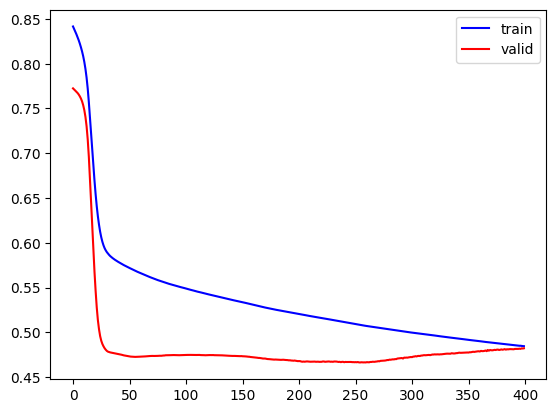

In [7]:
model = first_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

m1_train, m1_val = train(model, optimizer, 400, train_loader, val_loader, loss_fn)

plt.plot(range(400), m1_train, 'blue' , label = 'train')
plt.plot(range(400), m1_val, 'red' , label = 'valid')
plt.legend();

Second approach  
We fit a PCA to the training set and use it to transform the features.

In [8]:
#first we separate the features from the target.
train_feat = train_set.iloc[:, :-1].to_numpy()
val_feat = val_set.iloc[:, :-1].to_numpy()
test_feat = test_set.iloc[:, :-1].to_numpy()

In [9]:
#fit PCA to the training data
pca = PCA(n_components = 7)
pca.fit(train_feat)

#Concatenate the transformed features with the target labels.
#the label dataframe is transformed to numpy array, then back to dataframe, so the indices are reset.
train_pca_df = pd.concat([pd.DataFrame(pca.transform(train_feat)), train_set.iloc[:, -1]], axis = 1)
val_pca_df = pd.concat([pd.DataFrame(pca.transform(val_feat)), pd.DataFrame(val_set.iloc[:, -1].to_numpy())], axis = 1)
test_pca_df = pd.concat([pd.DataFrame(pca.transform(test_feat)), pd.DataFrame(test_set.iloc[:, -1].to_numpy())], axis = 1)

In [10]:
train_pca = CustomDataset(dataframe = train_pca_df)
train_loader_pca = DataLoader(train_pca, batch_size = 32)

val_pca = CustomDataset(dataframe = val_pca_df)
val_loader_pca = DataLoader(val_pca, batch_size = 32)

test_pca = CustomDataset(dataframe = test_pca_df)
test_loader_pca = DataLoader(test_pca, batch_size = 32)

Now we are ready to create a model, similar to the one used in the first example

In [11]:
class pca_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(7, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

model_pca = pca_model()

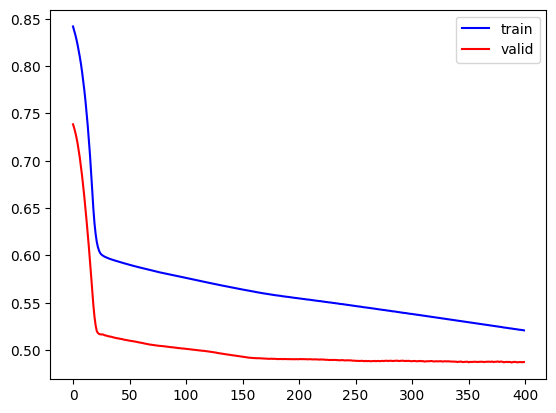

In [12]:
optimizer = torch.optim.Adam(model_pca.parameters(), lr = 1e-4)
m2_train, m2_val = train(model_pca, optimizer, 400, train_loader_pca, val_loader_pca, loss_fn)

plt.plot(range(400), m2_train, 'blue' , label = 'train')
plt.plot(range(400), m2_val, 'red' , label = 'valid')
plt.legend();

# Third approach: AE model

In [13]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(nn.Linear(11, 15),
                                     nn.ReLU(),
                                     nn.Linear(15, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 7),
                                     nn.ReLU()
                                    )
        self.decode = nn.Sequential(nn.Linear(7, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 15),
                                     nn.ReLU(),
                                     nn.Linear(15, 11),
                                     nn.Tanh()
                                    )
        
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [14]:
def train_step_ae(model, optimizer, dataloader, loss_fn):
    model.train()
    losses = []
    for x,y in train_loader:
        optimizer.zero_grad()
        x_pred = model(x)
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return sum(losses)/len(losses)

def evaluate_ae(model, dataloader, loss_fn):
    with torch.no_grad():
        model.eval()
        losses = []
        for x,y in dataloader:
            x_pred = model(x)
            loss = loss_fn(x_pred, x)
            losses.append(loss.detach())
            
    return sum(losses)/len(losses)

def train_ae(model, optimizer, epochs, train_loader, val_loader, loss_fn):
    train_loss, val_loss = [], []
    for i in range(epochs):
        #training
        new_loss = train_step_ae(model, optimizer, train_loader, loss_fn)
        train_loss.append(new_loss)
        #evaluating
        new_loss = evaluate_ae(model, val_loader, loss_fn)
        val_loss.append(new_loss)
        
    return train_loss, val_loss

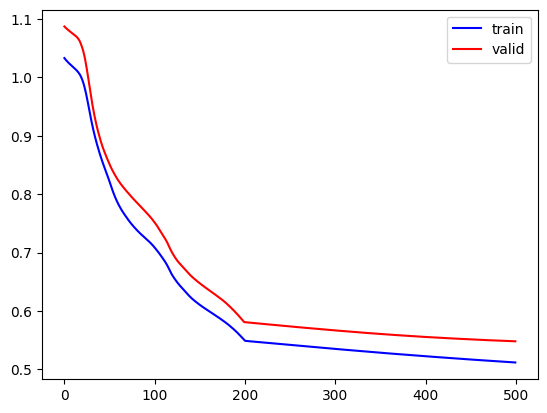

In [15]:
ae = AE()
loss_fn_ae = nn.MSELoss()

optimizer_ae = torch.optim.Adam(ae.parameters(), lr = 1e-4)
ae_train, ae_val = train_ae(ae, optimizer_ae, 400, train_loader, val_loader, loss_fn_ae)
#learning rate decay
optimizer_ae = torch.optim.Adam(ae.parameters(), lr = 1e-5)
ae_train2, ae_val2 = train_ae(ae, optimizer_ae, 300, train_loader, val_loader, loss_fn_ae)

plt.plot(range(700), ae_train + ae_train2, 'blue' , label = 'train')
plt.plot(range(700), ae_val + ae_val2, 'red' , label = 'valid')
plt.legend();

In [16]:
class Model_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.ae = ae.encode
        self.ff1 = nn.Linear(7, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = self.ae(x)
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

First we allow the model to retrain the parameters in the encoding network.

ValueError: x and y must have same first dimension, but have shapes (300,) and (400,)

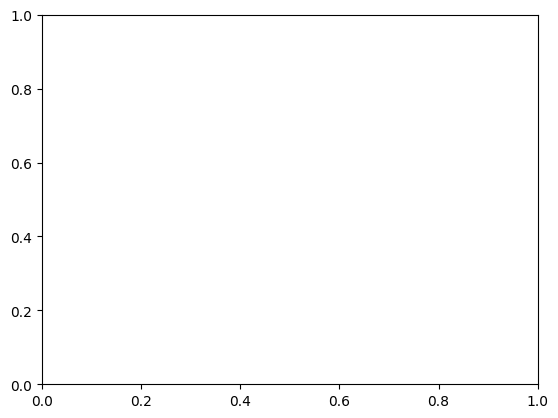

In [18]:
model_ae = Model_AE()

optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-4)
m3_train, m3_val = train(model_ae, optimizer, 200, train_loader, val_loader, loss_fn)

#lr decay
optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-5)
m3_train2, m3_val2 = train(model_ae, optimizer, 200, train_loader, val_loader, loss_fn)

plt.plot(range(300), m3_train + m3_train2, 'blue' , label = 'train')
plt.plot(range(300), m3_val + m3_val2, 'red' , label = 'valid')
plt.legend();

Now we initialize the model again, freeze the parameters of the encoding network and then train it again.

ValueError: x and y must have same first dimension, but have shapes (300,) and (700,)

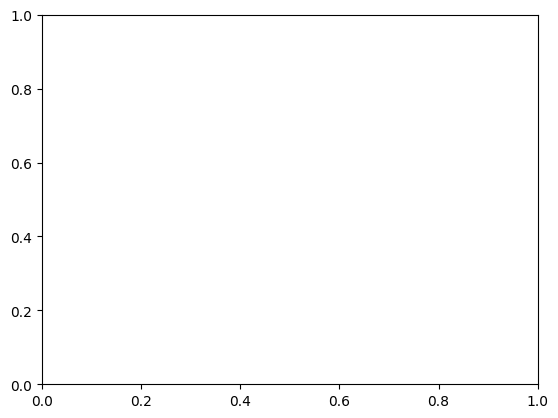

In [ ]:
model_ae_frozen = Model_AE()

#freeze encoder network:
for param in model_ae_frozen.ae.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-4)
m3_train, m3_val = train(model_ae, 400, train_loader, val_loader, loss_fn)

#lr decay
optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-5)
m3_train2, m3_val2 = train(model_ae, 300, train_loader, val_loader, loss_fn)

plt.plot(range(700), m3_train + m3_train2, 'blue' , label = 'train')
plt.plot(range(700), m3_val + m3_val2, 'red' , label = 'valid')
plt.legend();

### Conclusion
Given that our dataset was still relatively low dimensional (11 dims), fitting a model on the original features gives the best test results.  
However, we also observed that this model overfits the fastest on the training data, because the dataset is relatively small, reducing the dimensionality of the feature space, leads to models, which do not overfit as quickly.

In [ ]:
loss_fn = nn.L1Loss(reduction = 'mean')

m1_test = evaluate(model, test_loader, loss_fn)
m2_test = evaluate(model_pca, test_loader_pca, loss_fn)
m3_test = evaluate(model_ae, test_loader, loss_fn)
m4_test = evaluate(model_ae_frozen , test_loader, loss_fn)


print("Test scores for each of the models")
print(f"first model: {m1_test}:.4f \npca model {m2_test}:.4f \nae model unfrozen{m3_test}:.4f \nae model frozen{m4_test}:.4f ")

Test scores for each of the models
first model: 0.5520896911621094 | pca model 0.574485719203949 | ae model 0.5314435362815857


C:\Users\1888r\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
